Take a long time series of $N$ years to test how good/bad the climatological seasonal cycle estimated from $M < N$ years with $H \in \{1,2,3,4,5\}$ harmonic functions is.

Test on seNorge data

In [97]:
import xarray as xr
import os
from forecast_clarify.main import *
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import cmocean

In [43]:
wdir = '/projects/NS9001K/owul/projects/forecast_clarify/'
ddir = '/projects/NS9853K/DATA/senorge/tg/'

sample_file = wdir + 'data/external/sample_ts_senorge_tg_1957-2020_weekly.nc'

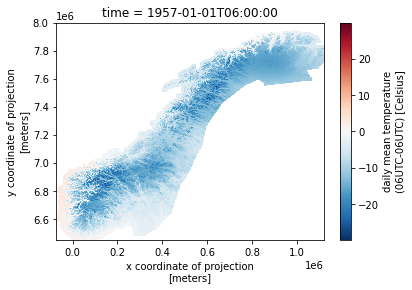

In [12]:
DS = xr.open_mfdataset(ddir + '*')
DS.isel(time=0).tg.plot()

In [28]:
# select an arbitrary point on the seNorge grid that contains data:
DS.isel(time=0,X=50,Y=1500).tg.values
# has a value, so can choose this one

array(1.20000005)

In [41]:
if not os.path.exists(sample_file):
    # load data into memory:
    temp = DS.isel(X=50,Y=1500).tg.resample(time='7D').mean()

    # save the timeseries for quicker access
    temp.to_netcdf()

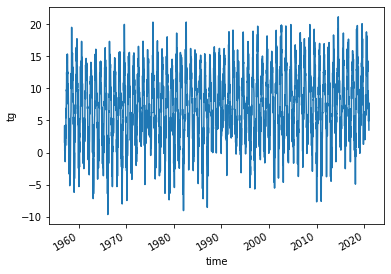

In [88]:
TS = xr.open_dataset(sample_file).drop(('X','Y','lat','lon'))
TS.tg.plot()

In [89]:
# split data into a training subset and a validation subset (1 year) that will be entirely withheld
TS_training = TS.sel(time=slice('1957','2015'))
TS_val = TS.sel(time=slice('2016','2020'))
# doy coordinate of the validation set:
val_doy = get_doy_coord(TS_val)

In [141]:
# number of harmonics:
H_list = list(range(1,6))

In [142]:
# withhold successively more years for the estimation:
STY = list(range(1957,2016))
cor,p,rmse = np.empty([3,len(STY),len(H_list)])
for yix,sty in enumerate(STY):
    TS_training_subset = TS_training.sel(time=slice(str(sty),'2015'))
    for hix,H in enumerate(H_list):
        # estimate the seasonal cycle from the training data:
        SC = seas_cycle(TS_training_subset,nharm=H)
        # estimate parameters of the harmonic fit:
        SC.fit()

        # predict the validation period:
        SC_pred = SC.predict(val_doy,time_name='time')

        cor[yix,hix], p[yix,hix] = pearsonr(SC_pred.tg,TS_val.tg)

        rmse[yix,hix] = ((SC_pred.tg - TS_val.tg)**2).mean('time').values**.5

Text(0, 0.5, 'number of years for estimation')

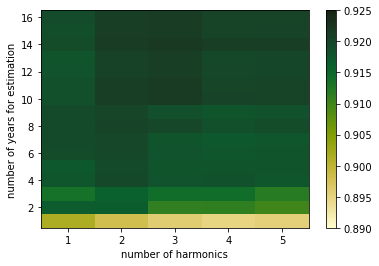

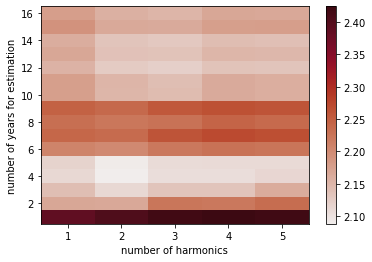

In [170]:
ylen = STY[-1] - np.array(STY) + 1
f,ax = plt.subplots(1,1)
co = ax.pcolormesh(H_list,ylen,cor,vmin=.89,vmax=.925,cmap=cmocean.cm.speed)
plt.colorbar(co,orientation='vertical')
ax.set_xlabel('number of harmonics')
ax.set_ylabel('number of years for estimation')

f,ax = plt.subplots(1,1)
rms = ax.pcolormesh(H_list,ylen,rmse,cmap=cmocean.cm.amp)
plt.colorbar(rms,orientation='vertical')
ax.set_xlabel('number of harmonics')
ax.set_ylabel('number of years for estimation')

!This needs a proper cross-validation to be meaningful!

Three harmonics seem pretty optimal for estimation in terms of correlation. For more harmonics, the seasonal cycle arguably captures frequencies that cannot be considered seasonal anymore and as the plot shows, the seasonal cycle does not generalize as well anymore.

Considering the RMSE, there seems to be no systematic reduction with the number of years (as long as there are more than 2!) and the number of harmonics seems to play a minor role although H = 2 looks like it might be best. 

!! Note that this might be to some degree location-dependent !!

Should this be compared to just averaging the years over a reasonable window (e.g. 30 days)? I would assume that for long time series, it amounts to basically the same, but will not work well for short time series at all!

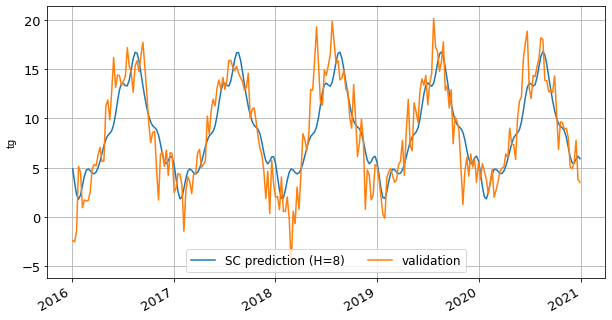

In [137]:
f,ax = plt.subplots(figsize=(10,5))

SC_pred.tg.plot(ax=ax,color='C0',label='SC prediction (H={0:d})'.format(H))
TS_val.tg.plot(ax=ax,color='C1',label='validation')

ax.legend(loc=8,fontsize=12,ncol=3)
ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel('')
ax.grid()

### Alternative Test:
Go by the assumption that we know the seasonal cycle and it is exactly the one estimated from the entire period 1957 - 2020 with a set $H$. Take periods of varying length to estimate this truth and check the fit (correlation and RMSE).

In [159]:
HA = 3

In [176]:
SC_true = seas_cycle(TS,nharm=HA)
SC_true.fit()

DOY = xr.DataArray(
        np.arange(1,366),
        coords=dict(time=(['time'],pd.date_range('2021-01-01','2021-12-31'))),
        dims=('time'),
        name='month_day'
        )

SC_true_sc = SC_true.predict(DOY)

In [192]:
STY = list(range(1970,2021))
STY[-1] - STY[0] + 1

51

In [198]:
for i in range(1):
    print('s')

s


In [211]:
# withhold successively more years for the estimation:
STY = list(range(1970,2021))
total_N = STY[-1] - STY[0] + 1
cor_sc,rmse_sc,cors_sc_mn,cors_sc_mx,rmse_sc_mn,rmse_sc_mx = np.empty([6,len(STY)])
for yix,sty in enumerate(STY):

    print(sty)

    # determine how many estimates can be made:
    NY = STY[-1] - sty + 1
    iters = total_N - NY

    CORR,RMSE = [],[]

    # with more years withheld, can use multiple different sub-periods (overlapping) for estimation:
    for ii in range(iters+1):

        start = STY[0] + ii
        end = STY[0] + ii + NY

        TS_training_subset = TS.sel(time=slice(str(start),str(end)))

        # estimate the seasonal cycle from the training data:
        SC_est = seas_cycle(TS_training_subset,nharm=HA)
        # estimate parameters of the harmonic fit:
        SC_est.fit()
        SC_est_sc = SC_est.predict(DOY)

        CORR.append(pearsonr(SC_true_sc.tg,SC_est_sc.tg)[0])

        RMSE.append(((SC_true_sc.tg - SC_est_sc.tg)**2).mean('time').values**.5)

    cor_sc[yix] = np.array(CORR).mean()
    cors_sc_mn[yix] = np.array(CORR).min()
    cors_sc_mx[yix] = np.array(CORR).max()
    rmse_sc[yix] = np.array(RMSE).mean()
    rmse_sc_mn[yix] = np.array(RMSE).min()
    rmse_sc_mx[yix] = np.array(RMSE).max()

1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020


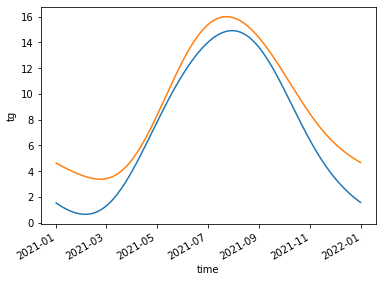

In [222]:
SC_true_sc.tg.plot()
SC_est_sc.tg.plot()

In [226]:
wdir

'/projects/NS9001K/owul/projects/forecast_clarify/'

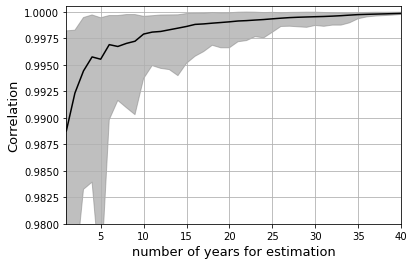

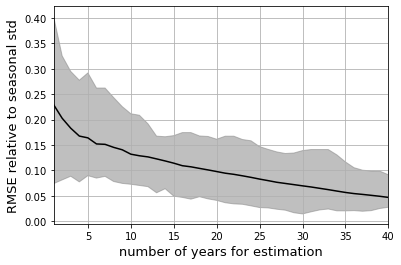

In [227]:
ylen = STY[-1] - np.array(STY) + 1
f,ax = plt.subplots(1,1)
ax.plot(ylen,cor_sc,color='k')
ax.fill_between(ylen,cors_sc_mn,cors_sc_mx,color='grey',alpha=.5)
ax.set_ylabel('Correlation',fontsize=13)
ax.set_xlabel('number of years for estimation',fontsize=13)
ax.grid()
ax.set_xlim([1,40])
ax.set_ylim([.98,1.0005])
f.savefig(wdir + '/data/processed/figures/correlation_range_true_est_subset.png',dpi=300)

scaling = SC_true_sc.tg.std().values
f,ax = plt.subplots(1,1)
ax.plot(ylen,rmse_sc/scaling,color='k')
ax.fill_between(ylen,rmse_sc_mn/scaling,rmse_sc_mx/scaling,color='grey',alpha=.5)
ax.set_ylabel('RMSE relative to seasonal std',fontsize=13)
ax.set_xlabel('number of years for estimation',fontsize=13)
ax.grid()
ax.set_xlim([1,40])
f.savefig(wdir + '/data/processed/figures/rmse_range_true_est_subset.png',dpi=300)

RMSE is more representative of the error in the amplitude. This is hard to reduce. Even with a sample of 40 years, the RMSE is still about 5% of the total std of the true seasonal cycle. The phase (as measured by the correlation) is captured easily with the harmonic approach, even from a limited number of years.